In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/advertising-dataset/advertising.csv


In [3]:
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import timeit
import xgboost as xgb

from pandas.plotting import scatter_matrix
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split


sns.set()
%matplotlib inline

In [4]:
df = pd.read_csv("/kaggle/input/advertising-dataset/advertising.csv")
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [6]:
df.isnull().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

In [7]:
df.duplicated().sum()

0

## EXPLORATORY ANALYSIS

In [8]:
# Train test split

train_df, validation_df = train_test_split(df, train_size = 0.75, random_state = 1)
train_df.head(2)

,TV,Radio,Newspaper,Sales
98,289.7,42.3,51.2,25.4
123,123.1,34.6,12.4,15.2


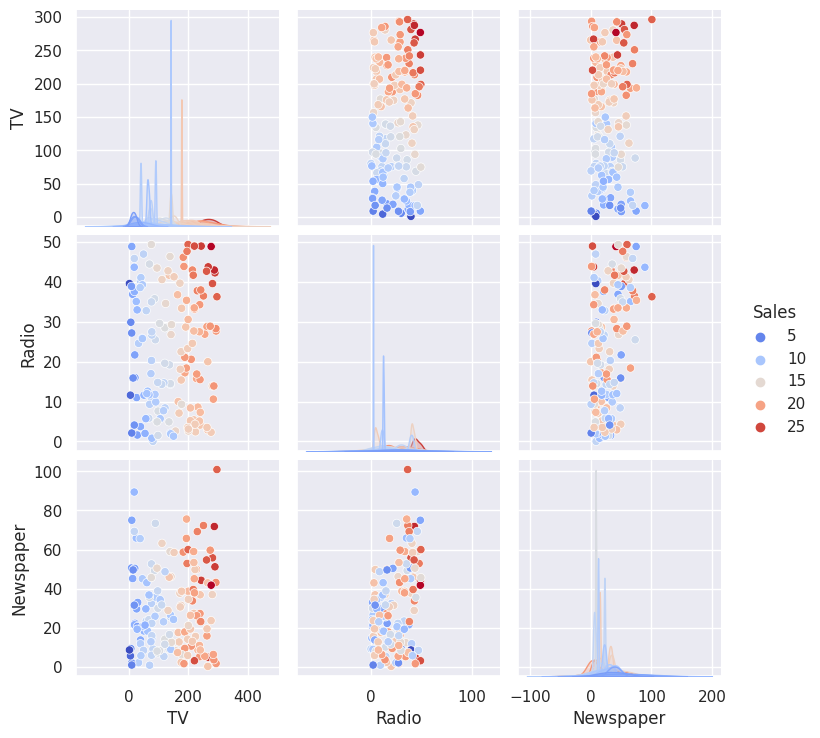

In [9]:
# Checking for the distribution of each variable through Pair plot

sns.pairplot(train_df, hue = "Sales",palette='coolwarm')
plt.show()


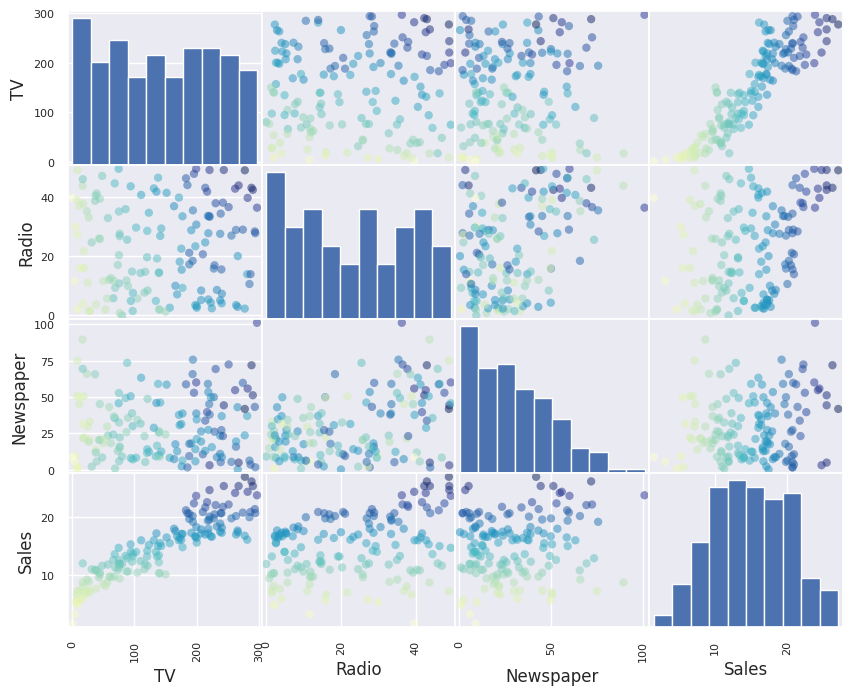

In [10]:
# Using scater-matrix plot

scatter_matrix(train_df, diagonal = "hist", marker = "o", c = train_df['Sales'], cmap = 'YlGnBu', figsize = (10,8))
plt.show()

## CHECKING FOR OUTLIERS

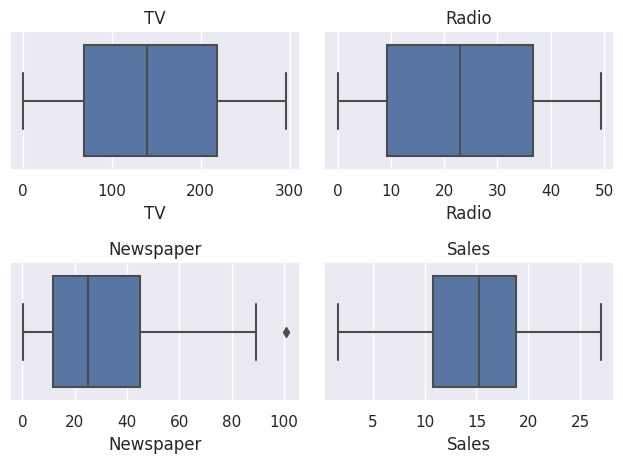

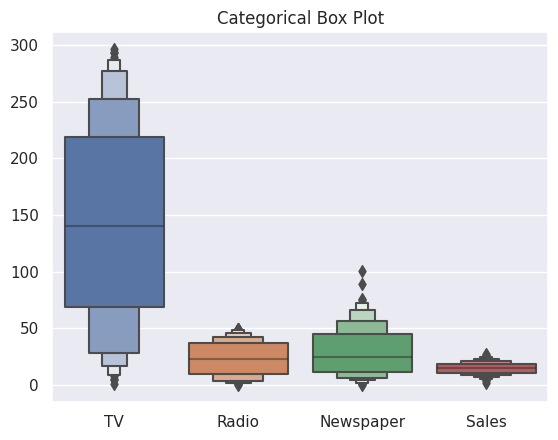

In [11]:
# Using box plot to see the distribution of each feature

plt.figure()

for col in train_df.select_dtypes(include = ['number']).columns:
    plt.subplot(2,2, train_df.columns.get_loc(col) + 1)  # Adjust the subplot layout as needed
    sns.boxplot(x=train_df[col])
    plt.title(col)

plt.tight_layout()
plt.show()


sns.boxenplot(data= train_df)
plt.title("Categorical Box Plot")
plt.show()

## CHECKING THE SALES DISTRUBUTION ACCROSS ALL PRODUCTS 

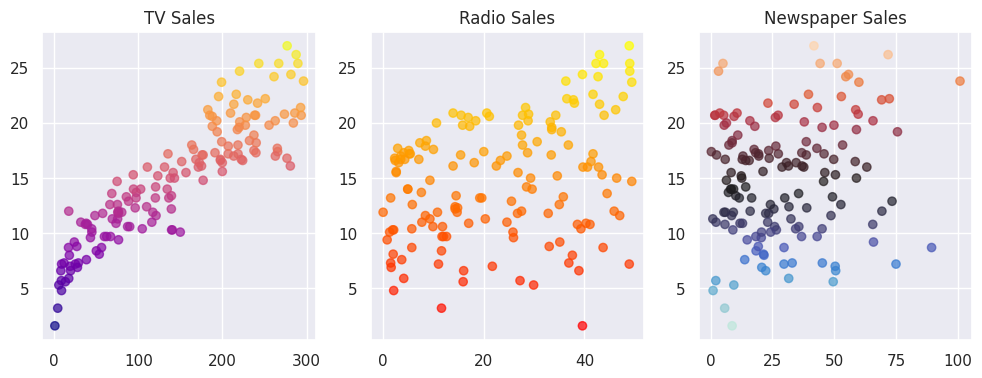

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(train_df['TV'], train_df['Sales'],c=train_df['Sales'], cmap='plasma', alpha=0.7)
plt.title('TV Sales')
plt.subplot(1, 3, 2)
plt.scatter(train_df['Radio'], train_df['Sales'],c=train_df['Sales'],cmap='autumn', alpha=0.7)
plt.title('Radio Sales')
plt.subplot(1, 3, 3)
plt.scatter(train_df['Newspaper'], train_df['Sales'], c=train_df['Sales'], cmap='icefire', alpha=0.7)
plt.title('Newspaper Sales')
plt.show()

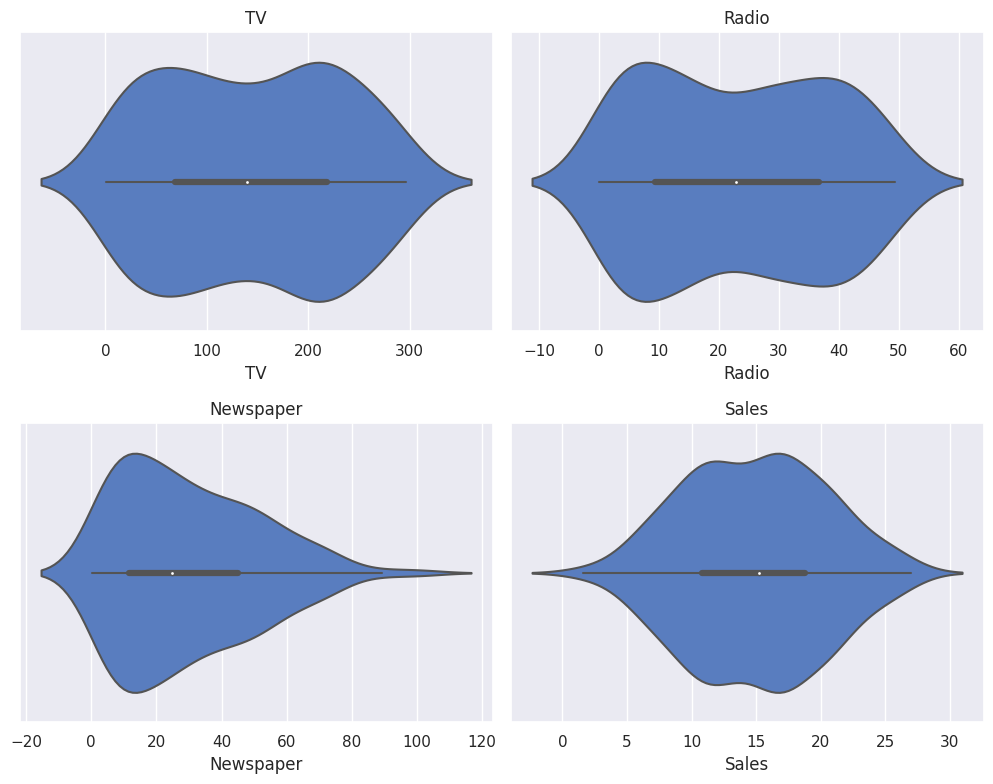

In [13]:
# Using violin plots to see a deper look into the distribution

plt.figure(figsize=(10, 8))

for col in train_df.select_dtypes(include = ['number']).columns:
    plt.subplot(2, 2, train_df.columns.get_loc(col) + 1)
    sns.violinplot(x=train_df[col], palette = 'muted')
    plt.title(col)

plt.tight_layout()
plt.show()

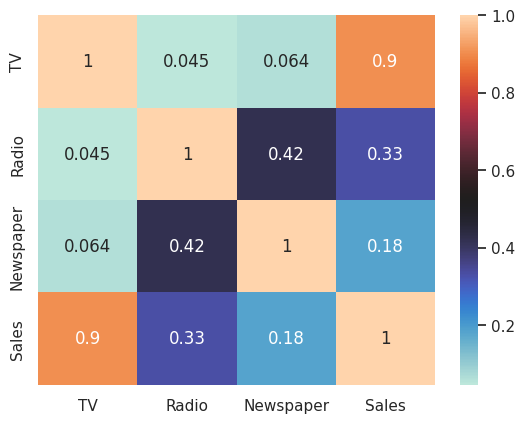

In [14]:
# Using heatmap to see the relationships

sns.heatmap(train_df.corr(), annot = True, cmap = "icefire")
plt.show()

In [15]:
# Getting the ad details of top 10 selling products
# To check for the effects of ads

top_10_products = train_df.nlargest(10, 'Sales')
top_10_products

,TV,Radio,Newspaper,Sales
175,276.9,48.9,41.8,27.0
183,287.6,43.0,71.8,26.2
98,289.7,42.3,51.2,25.4
36,266.9,43.8,5.0,25.4
147,243.2,49.0,44.3,25.4
128,220.3,49.0,3.2,24.7
17,281.4,39.6,55.8,24.4
61,261.3,42.7,54.7,24.2
101,296.4,36.3,100.9,23.8
55,198.9,49.4,60.0,23.7


### Analysis:

We can clearly see that products with increased TV ads, have increased sales.

While we have a mixed output in th eother categories.

We see a small amount of outliers in the Newspapers category, while the other categories have no outliers.

We can build models with and without outliers to check which is better.

We see that the Sales is highly correlated with TV and the the relation seems to be little less with the other categories.

## MODEL BUILDING

In [16]:
raw_x_train = train_df.drop(['Sales'], axis = 1)
raw_y_train = train_df['Sales']

raw_x_val = validation_df.drop(['Sales'], axis = 1)
raw_y_val = validation_df['Sales']

raw_x_train.head(2)

,TV,Radio,Newspaper
98,289.7,42.3,51.2
123,123.1,34.6,12.4


In [17]:
# Random Forest regression - Choosing max depth as 6 after trying different values
# Choosing the parameters after trying different values
rf_raw = RandomForestRegressor(n_estimators = 500, random_state = 1, max_depth = 6)
rf_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_rf = rf_raw.predict(raw_x_train)
raw_y_pred_val_rf = rf_raw.predict(raw_x_val)

print("Accuracy Scores for Random Forest model on raw data")
raw_rf_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_rf)
raw_train_rf_r2s = r2_score(raw_y_train, raw_y_pred_train_rf)
raw_val_rf_r2s = r2_score(raw_y_val, raw_y_pred_val_rf)
print("Mean Squared Error :", raw_rf_rmse)
print("R-squared Score (Train) :", raw_train_rf_r2s)
print("R-squared Score (Test) :", raw_val_rf_r2s)

Accuracy Scores for Random Forest model on raw data
Mean Squared Error : 0.8806058681446665
R-squared Score (Train) : 0.9845458009104096
R-squared Score (Test) : 0.9632489441280556


In [18]:
gb_raw = GradientBoostingRegressor(n_estimators = 100, max_depth = 3, random_state = 123)
gb_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_gb = gb_raw.predict(raw_x_train)
raw_y_pred_val_gb = gb_raw.predict(raw_x_val)

print("Accuracy Scores for Gradient Boost Regressor model on raw data")
raw_gb_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_gb)
raw_train_gb_r2s = r2_score(raw_y_train, raw_y_pred_train_gb)
raw_val_gb_r2s = r2_score(raw_y_val, raw_y_pred_val_gb)
print("Mean Squared Error :", raw_gb_rmse)
print("R-squared Score (Train) :", raw_train_gb_r2s)
print("R-squared Score (Test) :", raw_val_gb_r2s)

Accuracy Scores for Gradient Boost Regressor model on raw data
Mean Squared Error : 1.1391445627205372
R-squared Score (Train) : 0.9937833039361156
R-squared Score (Test) : 0.9524591341198211


In [19]:
# Support Vector Regression model - RBF kernel
svr_rbf_raw = SVR(kernel = 'rbf')
svr_rbf_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_svr_rbf = svr_rbf_raw.predict(raw_x_train)
raw_y_pred_val_svr_rbf = svr_rbf_raw.predict(raw_x_val)

print("Accuracy Scores for Support Vector Model with rbf kernel on raw data")
raw_svr_rbf_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_svr_rbf)
raw_train_svr_rbf_r2s = r2_score(raw_y_train, raw_y_pred_train_svr_rbf)
raw_val_svr_rbf_r2s = r2_score(raw_y_val, raw_y_pred_val_svr_rbf)
print("Root Mean Squared Error :", raw_svr_rbf_rmse)
print("R-squared Score (Train) :", raw_train_svr_rbf_r2s)
print("R-squared Score (Test) :", raw_val_svr_rbf_r2s)

Accuracy Scores for Support Vector Model with rbf kernel on raw data
Root Mean Squared Error : 2.8001123434574935
R-squared Score (Train) : 0.8752234628738097
R-squared Score (Test) : 0.8831405866066501


In [20]:
# Function for checking the best model out of the tested models for correlation treated dataset

def check_scores(mse_list, r2_train_list, r2_test_list, data):
    models_list = ['Random Forest Regression', 'Gradient Boosting Regression', 'SVR - RBF']

    accuracy = pd.DataFrame({'Method' : models_list, 'Mean Squared Error' : mse_list, 'R2Score(Training)' : r2_train_list,
                           'R2Score(Testing)' : r2_test_list})

    sns.lineplot(x = 'Method', y = 'Mean Squared Error', data = accuracy, label = 'MSE', color = 'green', linestyle = 'dashed', marker = 'o', markersize = 5, markerfacecolor = 'green')
    sns.lineplot(x = 'Method', y = 'R2Score(Training)', data = accuracy, label = 'R2Train', color = 'blue', linestyle = 'dashed', marker = 'o', markersize = 5, markerfacecolor = 'blue')
    sns.lineplot(x = 'Method', y = 'R2Score(Testing)', data = accuracy, label = 'R2Test', color = 'brown', linestyle = 'dashed', marker = 'o', markersize = 5, markerfacecolor = 'brown')
    plt.xticks(rotation = 90)
    plt.title("Accuracy on %s dataset" % data)
    plt.ylim(0.0, 3.0)
    plt.axhline(y = 0.7, linewidth = 1, color = 'red')
    plt.show()

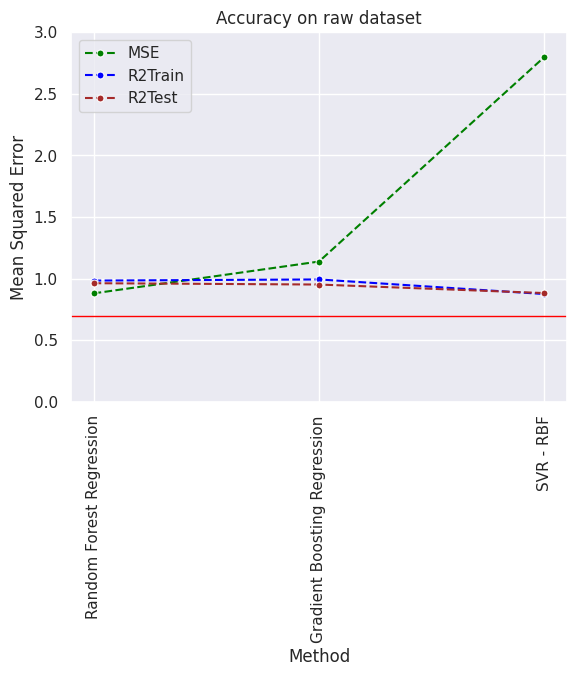

In [21]:
# Checking the accuracy of models on raw data

raw_mse_list = [ raw_rf_rmse, raw_gb_rmse, raw_svr_rbf_rmse] 

raw_r2_train_list = [raw_train_rf_r2s, raw_train_gb_r2s,raw_train_svr_rbf_r2s]

raw_r2_test_list = [ raw_val_rf_r2s,raw_val_gb_r2s, raw_val_svr_rbf_r2s]

check_scores(raw_mse_list, raw_r2_train_list, raw_r2_test_list, 'raw')

## CROSS VALIDATING
CROSS VALIDATING THE RANDOM FOREST REGRESSION MODEL AS IT HAS SHOWN THE HIGHESET ACCRATE PREDICTION FOR THE TEST DATSET

In [22]:
train_rf_raw = cross_val_score(rf_raw, raw_x_train, raw_y_train, cv = 10, scoring = 'r2')
val_rf_raw = cross_val_score(rf_raw, raw_x_val, raw_y_val, cv = 10, scoring = 'r2')

print("Cross validation on Random Forest with raw data")
print("Train Mean Accuracy", train_rf_raw.mean())
print("**************")
print("Train Max Accuracy", train_rf_raw.max())
print("**************"*7)
print("Test Mean Accuracy", val_rf_raw.mean())
print("**************")
print("Test Max Accuracy", val_rf_raw.max())
print("**************"*7)

elapsed_time_rf_scld_raw = timeit.timeit()
print(f"Elapsed Time: {elapsed_time_rf_scld_raw} seconds")

Cross validation on Random Forest with raw data
Train Mean Accuracy 0.9122690290061335
**************
Train Max Accuracy 0.9765015290709014
**************************************************************************************************
Test Mean Accuracy 0.8088273766939214
**************
Test Max Accuracy 0.9366075944900674
**************************************************************************************************
Elapsed Time: 0.014958120000073905 seconds


In [23]:
# Saving model for deployment

final_model = rf_raw
filename = 'Sales_Predictions.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [24]:
out_df = df

In [25]:
# Splitting dependent and independent variable

x_final = out_df.drop(['Sales'], axis = 1)
y_final = out_df['Sales']

In [26]:
# Predicting the Rating using Random Forest model that was chosen as final model

y_pred = final_model.predict(x_final)

final_result = pd.DataFrame(y_pred)
final_result = final_result.rename(columns = {0 : "Predicted_Sales"})
final_result

,Predicted_Sales
0,21.914317
1,10.538109
2,10.375141
3,16.596545
4,17.074889
...,...
195,7.995284
196,13.085124
197,15.922846
198,25.113205


In [27]:
final_result1 = pd.concat([df, pd.DataFrame(final_result)], axis = 1)
final_result1.head(5)

,TV,Radio,Newspaper,Sales,Predicted_Sales
0,230.1,37.8,69.2,22.1,21.914317
1,44.5,39.3,45.1,10.4,10.538109
2,17.2,45.9,69.3,12.0,10.375141
3,151.5,41.3,58.5,16.5,16.596545
4,180.8,10.8,58.4,17.9,17.074889


In [28]:
final_result1.to_csv("Predicted_Sales.csv")

# CONCLUSION :
_To predict the sales for the advertisment through T.V, News and Radio , where the Randomforst model proved to most accurate in this analysis_

- ### Note :
- _The Data in column T.V., Radio , Newspaper represents the 1000 Dollar budget where as the Sales is per 1000 units(Confirmed from the discussion section , for further query you can refer there)_